### Author: Ramim Tarafdar

#### Individual Project: Weather Forecast

5/7/24

Import necessary packages and dependencies.

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error


Load the National Center for Environmental Informations (NCEI)'s Global Historical Climatology Network - Daily (GHCN-Daily) CSV file into a DataFrame. The Global Historical Climatology Network - Daily (GHCN-Daily) dataset integrates daily climate observations from approximately 30 different data sources. Version 3 was released in September 2012 with the addition of data from two additional station networks. Changes to the processing system associated with the version 3 release also allowed for updates to occur 7 days a week rather than only on most weekdays. Version 3 contains station-based measurements from well over 90,000 land-based stations worldwide, about two thirds of which are for precipitation measurement only. Other meteorological elements include, but are not limited to, daily maximum and minimum temperature, temperature at the time of observation, snowfall and snow depth. Over 25,000 stations are regularly updated with observations from within roughly the last month. The dataset is also routinely reconstructed (usually every week) from its roughly 30 data sources to ensure that GHCN-Daily is generally in sync with its growing list of constituent sources. During this process, quality assurance checks are applied to the full dataset. Where possible, GHCN-Daily station data are also updated daily from a variety of data streams. Station values for each daily update also undergo a suite of quality checks.

In [67]:
df = pd.read_csv('central_park_weather_data.csv')
print(df.head())

       STATION      DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  USW00094728  1/1/2000  40.77898  -73.96925       42.7   
1  USW00094728  1/2/2000  40.77898  -73.96925       42.7   
2  USW00094728  1/3/2000  40.77898  -73.96925       42.7   
3  USW00094728  1/4/2000  40.77898  -73.96925       42.7   
4  USW00094728  1/5/2000  40.77898  -73.96925       42.7   

                          NAME  PRCP PRCP_ATTRIBUTES  SNOW SNOW_ATTRIBUTES  \
0  NY CITY CENTRAL PARK, NY US     0        ,,0,2400   0.0            ,,0,   
1  NY CITY CENTRAL PARK, NY US     0        ,,0,2400   0.0            ,,0,   
2  NY CITY CENTRAL PARK, NY US     0        ,,0,2400   0.0            ,,0,   
3  NY CITY CENTRAL PARK, NY US   178        ,,0,2400   0.0            ,,0,   
4  NY CITY CENTRAL PARK, NY US     0       T,,0,2400   0.0            ,,0,   

   ...  WT17 WT17_ATTRIBUTES  WT18 WT18_ATTRIBUTES  WT19 WT19_ATTRIBUTES  \
0  ...   NaN             NaN   NaN             NaN   NaN             NaN   
1  ...   NaN      

C:\Users\rtara\AppData\Local\Temp\ipykernel_20412\2476813337.py:1: DtypeWarning: Columns (39,57,61,95,99,103,105,107,109,111,113,115,117,119,123) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('central_park_weather_data.csv')


Preprocess the data to make it easier to work with
- drop unnecessary columns to predict temperature
- convert date to datetime format for index
- handle missing values

Necessary columns include:

- DATE: This column is essential for organizing the data by date.
- TMAX: Maximum temperature recorded for the day.
- TMIN: Minimum temperature recorded for the day.
- TAVG: Average temperature for the day.
- RHMX: Maximum relative humidity for the day.
- RHAV: Average relative humidity for the day.
- PRCP: Precipitation amount for the day.
- AWND: Average daily wind speed.
- SNWD: Snow depth on the ground.

In [68]:
# Drop unnecessary columns
columns_to_keep = ['DATE', 'TMAX', 'TMIN', 'TAVG', 'RHMX', 'RHAV', 'PRCP', 'AWND', 'SNWD']
df = df[columns_to_keep]

# Convert DATE column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

print(df.head())


        DATE  TMAX  TMIN   TAVG  RHMX  RHAV  PRCP  AWND  SNWD
0 2000-01-01   100    11   56.0   NaN   NaN     0  26.0   0.0
1 2000-01-02   156    61  111.0   NaN   NaN     0  21.0   0.0
2 2000-01-03   178   106  144.0   NaN   NaN     0  30.0   0.0
3 2000-01-04   156    78  117.0   NaN   NaN   178  35.0   0.0
4 2000-01-05    83   -17   33.0   NaN   NaN     0  51.0   0.0


Check for missing values in each column.


In [69]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

DATE       0
TMAX       0
TMIN       0
TAVG    6873
RHMX    2379
RHAV    2381
PRCP       0
AWND     257
SNWD     108
dtype: int64


Ensure no null values are in dataset and input average values for missing entries.

In [70]:
# Calculate average temperature (TAVG) using TMAX and TMIN
df['TAVG'] = (df['TMAX'] + df['TMIN']) / 2

# Input missing values for numerical features using mean
df.fillna({'RHMX': df['RHMX'].mean(), 'RHAV': df['RHAV'].mean(), 
           'AWND': df['AWND'].mean(), 'SNWD': df['SNWD'].mean()}, inplace=True)

# Check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

DATE    0
TMAX    0
TMIN    0
TAVG    0
RHMX    0
RHAV    0
PRCP    0
AWND    0
SNWD    0
dtype: int64


In [93]:
print(df.head())

        DATE  TMAX  TMIN   TAVG       RHMX       RHAV  PRCP  AWND  SNWD
0 2000-01-01   100    11   55.5  78.875921  61.450691     0  26.0   0.0
1 2000-01-02   156    61  108.5  78.875921  61.450691     0  21.0   0.0
2 2000-01-03   178   106  142.0  78.875921  61.450691     0  30.0   0.0
3 2000-01-04   156    78  117.0  78.875921  61.450691   178  35.0   0.0
4 2000-01-05    83   -17   33.0  78.875921  61.450691     0  51.0   0.0


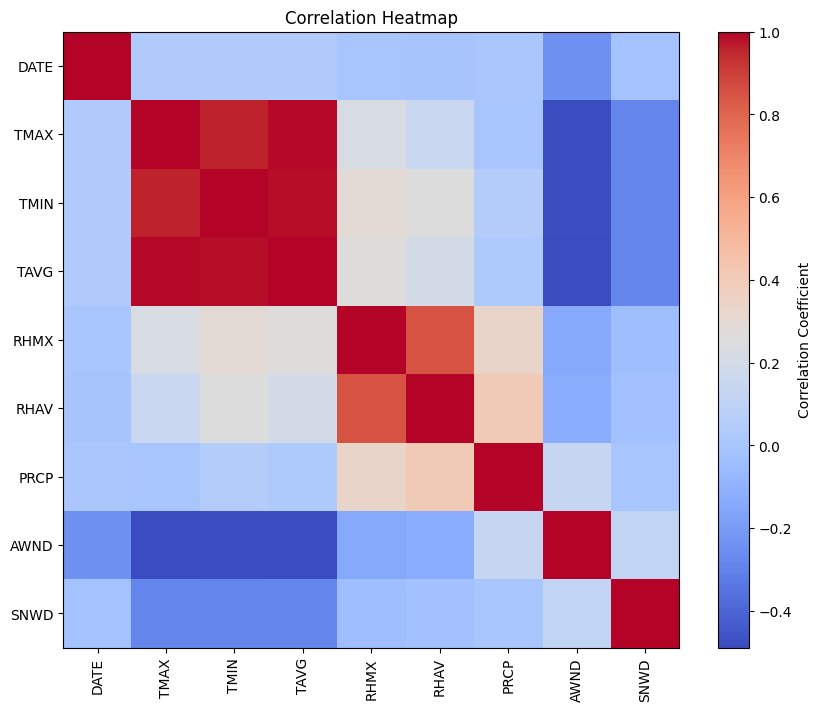

In [94]:
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Heatmap')
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.show()


Define the features and target variables. Since we are attempting to predict the temperature, TAVG will be the target variable and the remaining columns, excluding DATE, will be the features. X will contain the feaures while Y contains the target.

Separate the data (the 150 data samples) into a training set and a testing set, using the Scikit learn function “train_test_split” 
	- X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=XYZ)
	- “XYZ” are the last three digits of your student id.

In [71]:
# Define features and target variable
X = df.drop(columns=['DATE', 'TAVG'])  # Features
Y = df['TAVG']  # Target

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=504)

In [72]:
X_train.head()


,TMAX,TMIN,RHMX,RHAV,PRCP,AWND,SNWD
692,144,67,78.875921,61.450691,0,24.0,0.0
3288,-33,-94,56.000000,43.000000,0,50.0,0.0
1342,239,200,78.875921,61.450691,48,12.0,0.0
6433,250,178,97.000000,86.000000,28,15.0,0.0
5786,211,133,87.000000,63.000000,0,11.0,0.0


In [73]:
Y_train.head()

692     105.5
3288    -63.5
1342    219.5
6433    214.0
5786    172.0
Name: TAVG, dtype: float64

In [74]:
# Print the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (7112, 7)
X_test shape: (1779, 7)
Y_train shape: (7112,)
Y_test shape: (1779,)


Train Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize the model
linear_reg = LinearRegression()

# Train the model
linear_reg.fit(X_train, Y_train)


Train Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the model
decision_tree = DecisionTreeRegressor()

# Train the model
decision_tree.fit(X_train, Y_train)


Train Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
random_forest = RandomForestRegressor()

# Train the model
random_forest.fit(X_train, Y_train)


Train Neural Network Model

In [ ]:
import tensorflow as tf

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2)


### Evaluate Model Performance

In [89]:
from sklearn.metrics import accuracy_score

# Linear Regression
linear_reg_accuracy = linear_reg.score(X_test, Y_test)
linear_reg_pred = linear_reg.predict(X_test)
linear_reg_mae = mean_absolute_error(Y_test, linear_reg_pred)
linear_reg_mse = mean_squared_error(Y_test, linear_reg_pred)

# Decision Tree
decision_tree_accuracy = decision_tree.score(X_test, Y_test)
decision_tree_pred = decision_tree.predict(X_test)
decision_tree_mae = mean_absolute_error(Y_test, decision_tree_pred)
decision_tree_mse = mean_squared_error(Y_test, decision_tree_pred)

# Random Forest
random_forest_accuracy = random_forest.score(X_test, Y_test)
random_forest_pred = random_forest.predict(X_test)
random_forest_mae = mean_absolute_error(Y_test, random_forest_pred)
random_forest_mse = mean_squared_error(Y_test, random_forest_pred)

# Neural Network
nn_accuracy = model.evaluate(X_test, Y_test, verbose=0)
nn_pred = model.predict(X_test)
nn_mae = mean_absolute_error(Y_test, nn_pred)
nn_mse = mean_squared_error(Y_test, nn_pred)

# Print MAE, MSE, and Accuracy for each model
print("Linear Regression Accuracy:", linear_reg_accuracy)
print("Linear Regression MAE:", linear_reg_mae)
print("Linear Regression MSE:", linear_reg_mse, "\n")

print("Decision Tree Accuracy:", decision_tree_accuracy)
print("Decision Tree MAE:", decision_tree_mae)
print("Decision Tree MSE:", decision_tree_mse, "\n")

print("Random Forest Accuracy:", random_forest_accuracy)
print("Random Forest MAE:", random_forest_mae)
print("Random Forest MSE:", random_forest_mse, "\n")

print("Neural Network Accuracy:", nn_accuracy)
print("Neural Network MAE:", nn_mae)
print("Neural Network MSE:", nn_mse)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
Linear Regression Accuracy: 1.0
Linear Regression MAE: 3.925872590759059e-14
Linear Regression MSE: 2.578634041781354e-27 

Decision Tree Accuracy: 0.9997594718296515
Decision Tree MAE: 0.39151208544125915
Decision Tree MSE: 2.1077852726250703 

Random Forest Accuracy: 0.9998605378074743
Random Forest MAE: 0.31425801011804383
Random Forest MSE: 1.2221285975267002 

Neural Network Accuracy: 0.1193799376487732
Neural Network MAE: 0.244902218739644
Neural Network MSE: 0.11986032992672775


In [80]:
# Make predictions using each model
linear_reg_predictions = linear_reg.predict(X_test)
decision_tree_predictions = decision_tree.predict(X_test)
random_forest_predictions = random_forest.predict(X_test)
nn_predictions = model.predict(X_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


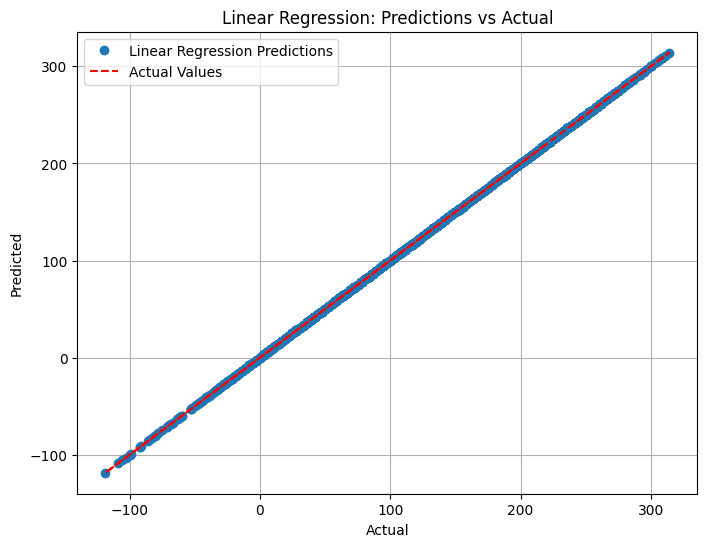

In [81]:
# Make predictions using the linear regression model
linear_reg_predictions = linear_reg.predict(X_test)

# Plot linear regression predictions vs actual
plt.figure(figsize=(8, 6))
plt.plot(Y_test, linear_reg_predictions, 'o', label='Linear Regression Predictions')
plt.plot(Y_test, Y_test, color='r', linestyle='--', label='Actual Values')
plt.title('Linear Regression: Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)
plt.show()


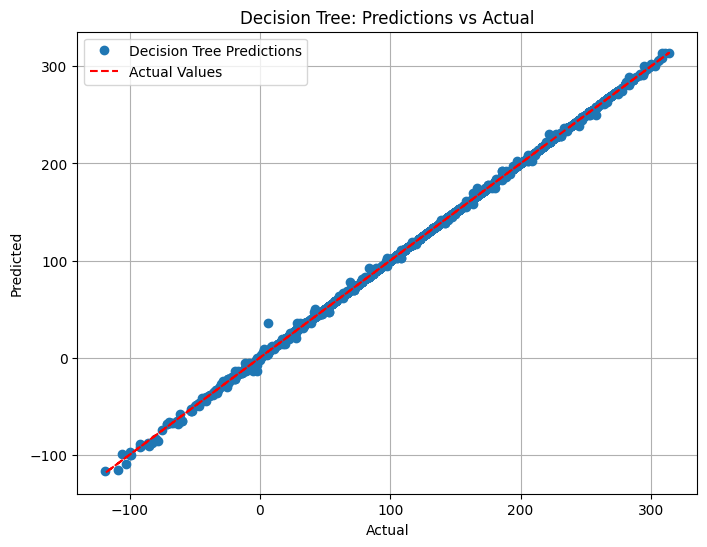

In [82]:
# Make predictions using the decision tree model
decision_tree_predictions = decision_tree.predict(X_test)

# Plot decision tree predictions vs actual
plt.figure(figsize=(8, 6))
plt.plot(Y_test, decision_tree_predictions, 'o', label='Decision Tree Predictions')
plt.plot(Y_test, Y_test, color='r', linestyle='--', label='Actual Values')
plt.title('Decision Tree: Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)
plt.show()

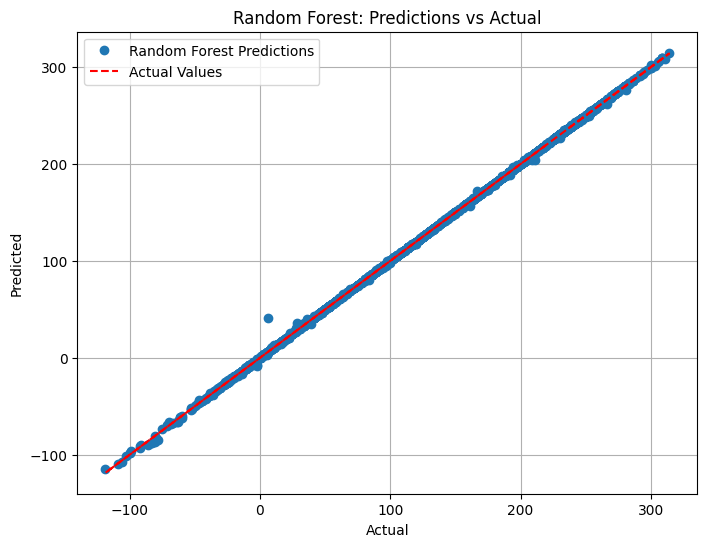

In [83]:
# Make predictions using the random forest model
random_forest_predictions = random_forest.predict(X_test)

# Plot random forest predictions vs actual
plt.figure(figsize=(8, 6))
plt.plot(Y_test, random_forest_predictions, 'o', label='Random Forest Predictions')
plt.plot(Y_test, Y_test, color='r', linestyle='--', label='Actual Values')
plt.title('Random Forest: Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)
plt.show()


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step


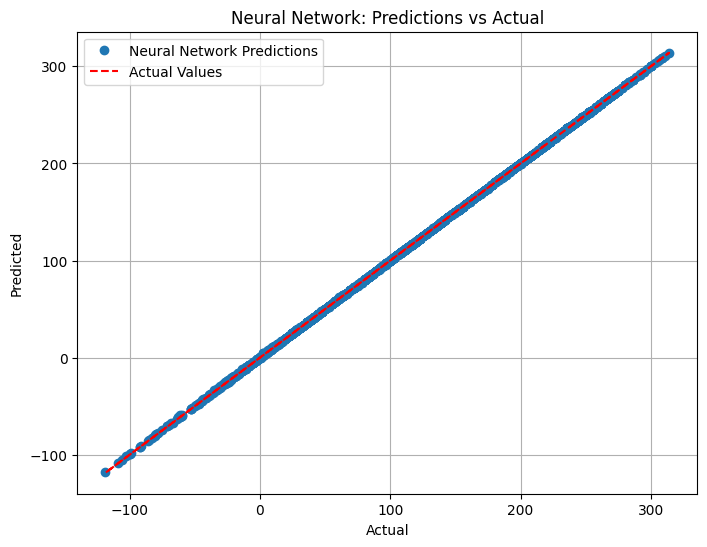

In [84]:
# Make predictions using the neural network model
neural_network_predictions = model.predict(X_test)

# Plot neural network predictions vs actual
plt.figure(figsize=(8, 6))
plt.plot(Y_test, neural_network_predictions, 'o', label='Neural Network Predictions')
plt.plot(Y_test, Y_test, color='r', linestyle='--', label='Actual Values')
plt.title('Neural Network: Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)
plt.show()

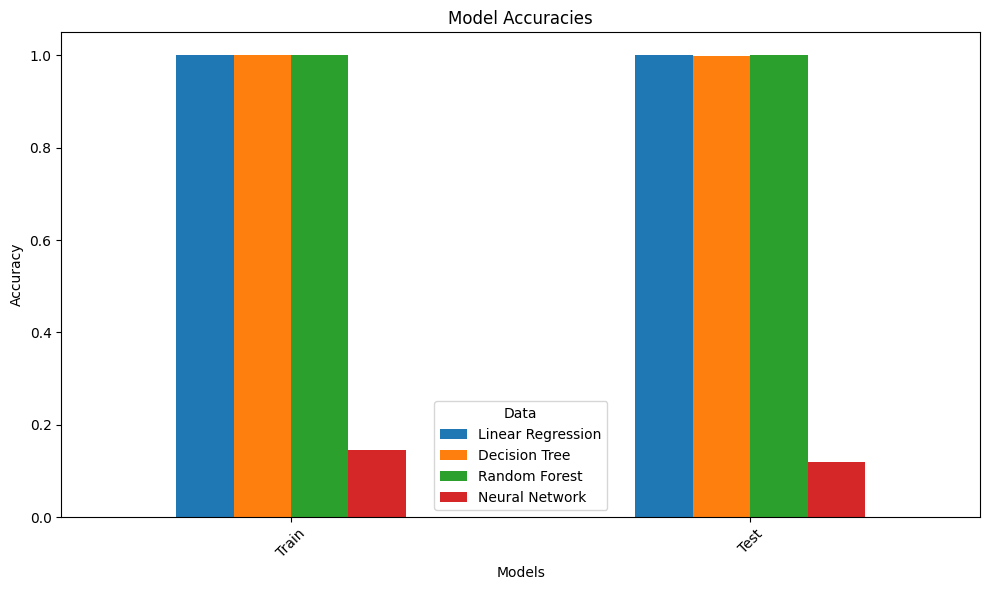

In [91]:
# Calculate accuracies for each model
linear_reg_train_accuracy = linear_reg.score(X_train, Y_train)
linear_reg_test_accuracy = linear_reg.score(X_test, Y_test)

decision_tree_train_accuracy = decision_tree.score(X_train, Y_train)
decision_tree_test_accuracy = decision_tree.score(X_test, Y_test)

random_forest_train_accuracy = random_forest.score(X_train, Y_train)
random_forest_test_accuracy = random_forest.score(X_test, Y_test)

# Train neural network model
nn_train_accuracy = model.evaluate(X_train, Y_train, verbose=0)
nn_test_accuracy = model.evaluate(X_test, Y_test, verbose=0)

# Store accuracies in a dictionary
accuracies = {
    'Linear Regression': {'Train': linear_reg_train_accuracy, 'Test': linear_reg_test_accuracy},
    'Decision Tree': {'Train': decision_tree_train_accuracy, 'Test': decision_tree_test_accuracy},
    'Random Forest': {'Train': random_forest_train_accuracy, 'Test': random_forest_test_accuracy},
    'Neural Network': {'Train': nn_train_accuracy, 'Test': nn_test_accuracy}
}

# Convert accuracies dictionary to DataFrame for visualization
accuracies_df = pd.DataFrame(accuracies)

# Plotting
accuracies_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Data')
plt.tight_layout()
plt.show()

